# Sıfırdan ResNet Yazımı

## Residual Network

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Conv2D, \
                                    Dense, Flatten, GlobalAveragePooling2D

import tensorflow_datasets as tfds

import numpy as np

import time

import matplotlib.pyplot as plt

print(tf.__version__)

2.8.0


In [2]:
train_data, test_data = tfds.load('cifar10', 
                                  split = ['train',
                                            'test'],
                                  as_supervised = True)

#### Verisetinin Yüklenmesi

In [3]:
def normalize_ohe(images, labels):
  return tf.cast(images, tf.float32) / 255.0, tf.one_hot(labels, 10)

def dataset_hazirla(ds):
  ds = ds.batch(64)
  ds = ds.map(normalize_ohe)
  ds = ds.shuffle(len(ds) // 10)
  return ds.prefetch(tf.data.AUTOTUNE)

train_data = dataset_hazirla(train_data)
test_data = dataset_hazirla(test_data)

In [4]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

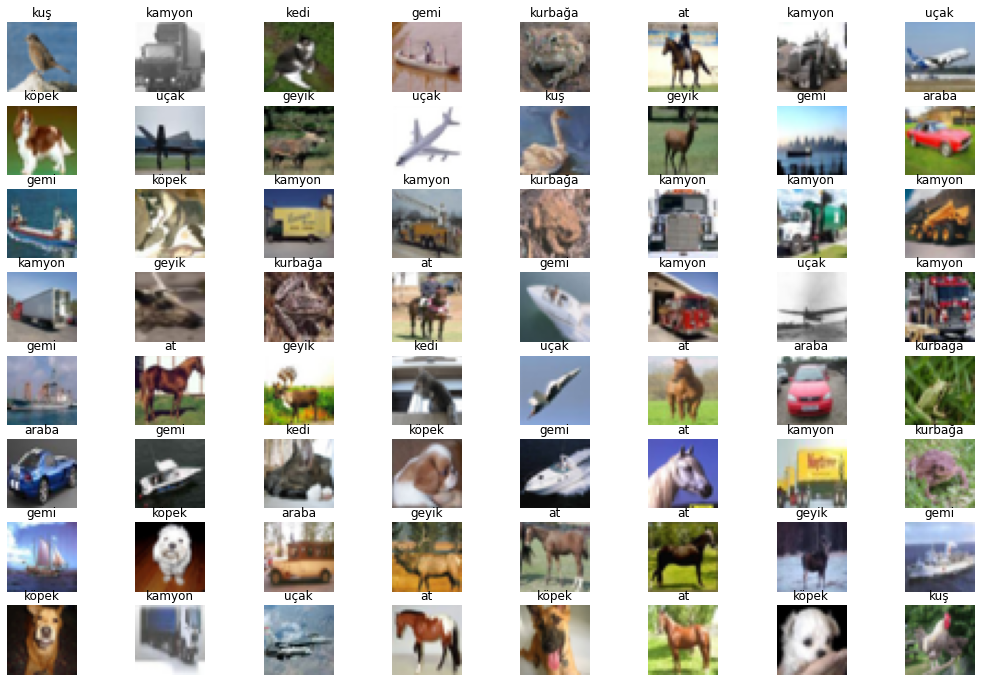

In [5]:
siniflar = ['uçak', 'araba', 'kuş', 
            'kedi', 'geyik', 'köpek',
            'kurbağa', 'at', 'gemi', 'kamyon']

def veri_gorsellestir(ds):
  plt.figure(figsize=(18,12))
  for images, labels in ds.take(1):
    for i in range(64):
      plt.subplot(8, 8, i+1)
      plt.imshow(images[i].numpy())
      plt.title(siniflar[tf.argmax(labels[i].numpy())])
      plt.axis('off')

veri_gorsellestir(train_data)

#### Residual Blokları için Özel Layerlar

Subclassing kullanarak kendi ihtiyaçlarımıza uygun özel, default olarak tanımlı olmayan layerlar oluşturabiliriz.

* Özel layer yaparken `__init__`, `build` ve `call` metotlarını kullanacağız. `__init__` ana [Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer) sınıfını çağırıp herhangi bir arguman vermişsek onları gönderiyor.

* `build` metodu layerları belirlediğimiz özelliklere göre oluşturuyor. Sırasıyla şu layerları kullanacağız:
    * BatchNormalization layer: İlk layer olduğu için `input_shape` parametresi alacak.
    * Conv2D
    * BatchNormalization
    * Conv2D

* `call` metodu verdiğimiz inputları layerlar üzerinde işleyecek. Yani asıl hesaplama yapılan graf burada oluşturulmuş oluyor. Hesaplamaları nasıl yapacağımızı burada özelliştirip, belirtiyoruz.
    * BatchNorm layerlarında `training` diye bir arguman yazacağız. 
    ** `training = False`: Layer, gelen inputları training sırasında öğrendiği hareketli ortalama ve varyansa göre normalize edecektir.
    ** `training = True`: Layer, mevcut batch grubunun ortalamasını ve varyansını kullanarak normalize eder.

In [6]:
class ResidualLayer(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(ResidualLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        
        self.bn1 = BatchNormalization(input_shape=input_shape)
        
        # Çıktı bir önceki layerdan gelen output ile ekleneceği
        # için, filtre sayısı input_shape[-1].
        # (16, 1, 1, 32) gibi bir input gelirse filtreler 32 olacak.
        self.conv1 = Conv2D(filters = input_shape[-1],
                            kernel_size = (3,3), 
                            padding='same')
        self.bn2 = BatchNormalization()
        self.conv2 = Conv2D(filters = input_shape[-1], 
                            kernel_size = (3,3), 
                            padding='same')

    def call(self, inputs, training=False):
        # Her layerı sırasıyla call ediyoruz. 
        # Functional API da aynı mantık değil mi zaten :)
        x = self.bn1(inputs, training = training)
        x = tf.nn.relu(x)
        
        x = self.conv1(x)
        x = self.bn2(x, training = training)
        x = tf.nn.relu(x)

        x = self.conv2(x)
        x = tf.keras.layers.Add()([x, inputs])
        return x

    # Plot etmek için böyle bir şey gerekiyor.
    # Yani kısaca TensorFlow'a bunun bir model olduğunu
    # söylersek, layerları direkt olarak görselleştirebiliriz.
    def build_graph(self, input_shape):
        x = tf.keras.Input(shape=(input_shape))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))        

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 3, 32)]   0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 3, 3, 32)    128         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 tf.nn.relu (TFOpLambda)        (None, 3, 3, 32)     0           ['batch_normalization[0][0]']    
                                                                                                  
 conv2d (Conv2D)                (None, 3, 3, 32)     9248        ['tf.nn.relu[0][0]']         

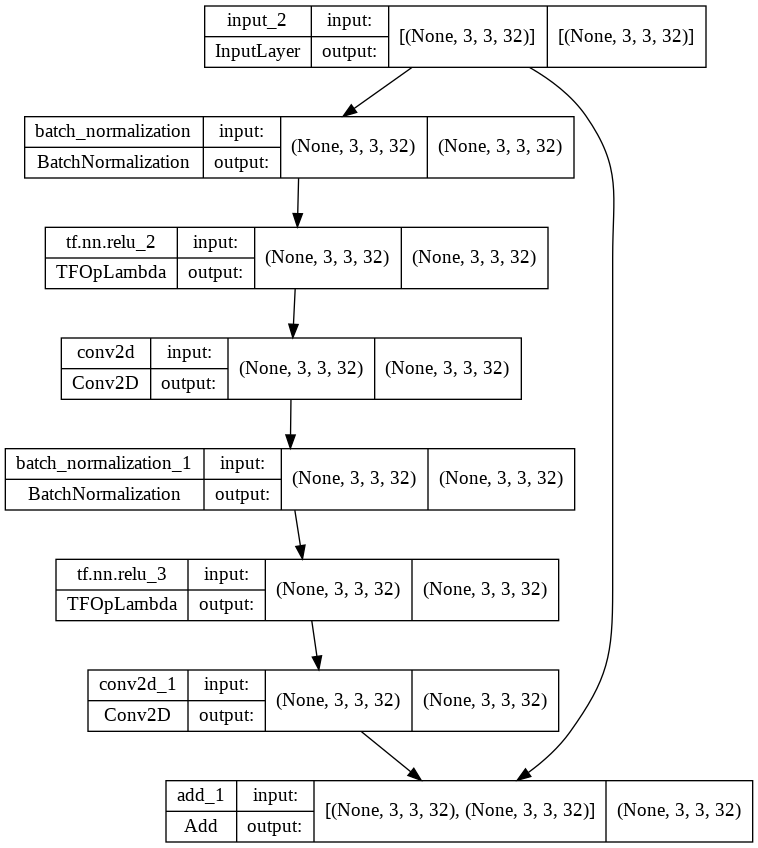

In [7]:
# Özel layerı test edebiliriz.
test = ResidualLayer(input_shape=((3, 3, 32)))
test.build((None, *(3,3,32)))
test.build_graph((3,3,32)).summary()

tf.keras.utils.plot_model(
    test.build_graph((3,3,32)),
    to_file='test.png',
    show_shapes=True, 
    show_layer_names=True,
    expand_nested=False                       
)

#### Residual Bloğunda Filtre Değiştirmek

Şimdi başka bir özel layer yazacağız. Residual bloğundaki filtre sayısını değiştirmek için bu layerı kullanacağız.


* Kullanacağımız metotlar yine aynı olacak, tek fark `__init__` metotu `out_filters` argumanı alacak ve bunu class niteliği olarak kaydedecek.

* Sırasıyla yazacağımız layerlar:
    * BatchNormalization layer: İlk layer olduğu için `input_shape` alacak. 
    * Conv2D
    * BatchNormalization
    * Conv2D: `out_filters` kadar filtresi olacak, 3x3 kernel size, `"SAME"` padding, aktivasyon fonksiyonu olmayacak.
    * Conv2D: `out_filters` kadar filtresi olacak fakat `kernel_size` olarak 1x1 kullanacağız.

* Süreç yine aynı, `call` metodu ile inputları layerlar üzerinde işleyeceğiz.
* 3.convolution layerını direkt olarak gelen inputa bağlayıp, 2.convolution sonucuyla toplayacağız.

In [8]:
class ResidualFilterChange(tf.keras.layers.Layer):

    def __init__(self, out_filters, **kwargs):
        super(ResidualFilterChange, self).__init__(**kwargs)
        self.out_filters = out_filters  
        
    def build(self, input_shape):
        self.bn1 = BatchNormalization(input_shape=input_shape)
        self.conv1 = Conv2D(filters = input_shape[-1], 
                            kernel_size = (3,3), 
                            padding='same')
        
        self.bn2 = BatchNormalization()
        
        self.conv2 = Conv2D(filters = self.out_filters,
                            kernel_size = (3,3), 
                            padding='same', name = 'SonConv')

        self.conv3 = Conv2D(filters = self.out_filters,
                            kernel_size = (1,1), # 1x1 DİKKAT!!
                            # 1x1 mantığını aşağıda açıklıyorum.
                            padding = 'valid', name = 'ResidualConv')        
        

    def call(self, inputs, training = False):
      # Önceki layer Add ile bitiyordu. Çıktıya BN + Relu uygulanacak.
        x = self.bn1(inputs, training = training)
        x = tf.nn.relu(x)
        x = self.conv1(x)

        x = self.bn2(x, training = training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = tf.keras.layers.Add()([x, self.conv3(inputs)])
        return x

    def build_graph(self, input_shape):
        x = tf.keras.Input(shape=(input_shape))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))            

In [9]:
# KISACA 1x1 kernel örneği ve derinlik azaltma.
# Performansı çok etkilemez.

input_demo = tf.random.uniform((1, 28, 28, 192))
conv_demo = Conv2D(filters = 16, kernel_size = (1,1),
                   padding = 'same')
model1 = tf.keras.Sequential([conv_demo])
print('1x1 Convolution operasyonundan önce:', input_demo.shape)
print('1x1 Convolution operasyonundan sonra:', model1(input_demo).shape)
print('\n----------Model1 Summary----------\n')
model1.summary()

conv_demo2 = Conv2D(filters = 16, kernel_size = (3,3),
                    padding = 'same')
model2 = tf.keras.Sequential([conv_demo2])
print('\n1x1 Convolution kullanmadan:\n', model2(input_demo).shape)
print('\n----------Model2 Summary----------\n')
model2.summary()

print('1x1 Convolutionda hesaplanması gereken parametre %d, 3x3 olanda %d'
      % (model1.count_params(), model2.count_params()))

1x1 Convolution operasyonundan önce: (1, 28, 28, 192)
1x1 Convolution operasyonundan sonra: (1, 28, 28, 16)

----------Model1 Summary----------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (1, 28, 28, 16)           3088      
                                                                 
Total params: 3,088
Trainable params: 3,088
Non-trainable params: 0
_________________________________________________________________

1x1 Convolution kullanmadan:
 (1, 28, 28, 16)

----------Model2 Summary----------

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (1, 28, 28, 16)           27664     
                                                                 
Total params: 27,664
Trainable params: 27,664
Non-trainable params:

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 64)  0           []                               
                                ]                                                                 
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 32, 32, 64)  256         ['input_3[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 tf.nn.relu_4 (TFOpLambda)      (None, 32, 32, 64)   0           ['batch_normalization_2[0][0]']  
                                                                                            

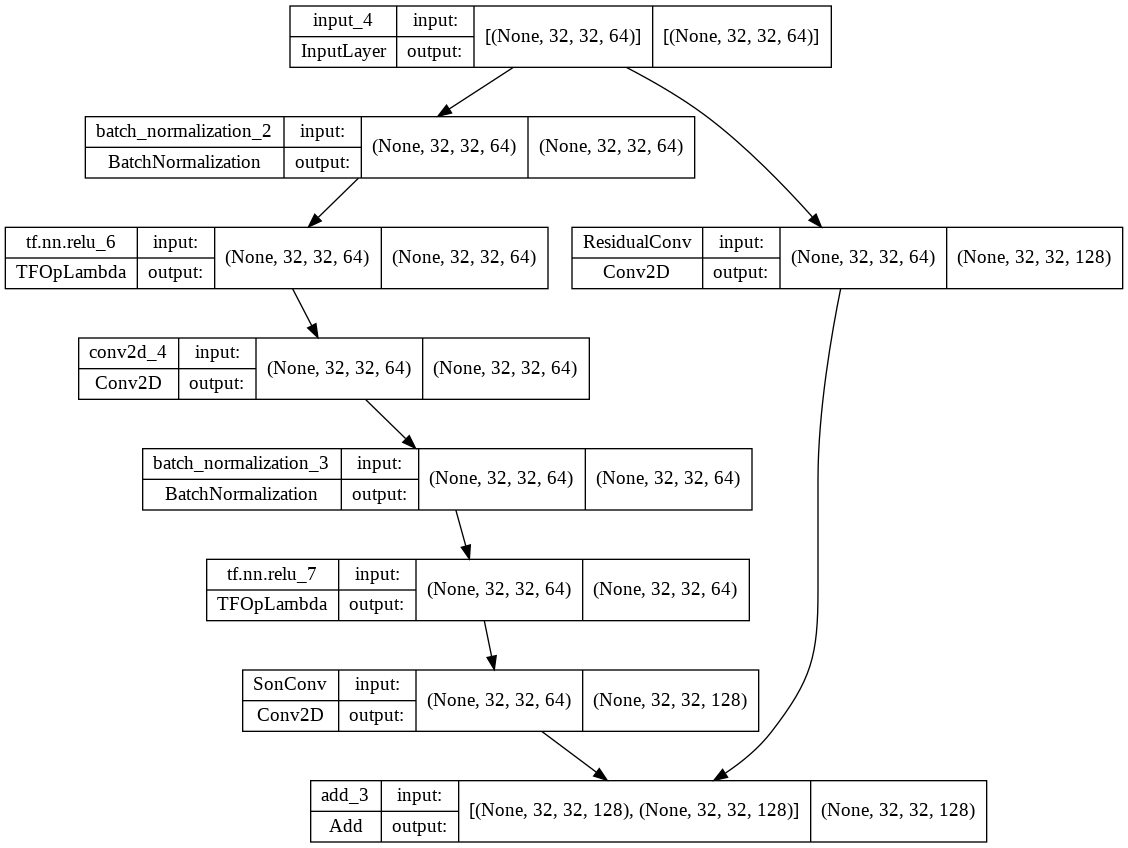

In [10]:
# Özel layerı test edebiliriz.

test = ResidualFilterChange(input_shape = ((32, 32, 64)), 
                                  out_filters = 128)
test.build((None, *(32, 32, 64)))
test.build_graph((32, 32, 64)).summary()

tf.keras.utils.plot_model(
    test.build_graph((32, 32, 64)),
    to_file='test.png',
    show_shapes=True, 
    show_layer_names=True,
    expand_nested=False                       
)

#### Model Subclassing

Model subclassing kullanarak ResNet modelini oluşturacağız.

* Modelin `__init__` ve `call` methodları olacak.
* Model layerları şu şekilde olacak:
    * İlk Conv2D layerında 32 filtre, 7x7 kernel size olacak ve strides 2 verilecek
    * Bir `ResidualBlock` eklenecek.
    * İkinci Conv2D layerı gelecek.
    * Bir adet `FiltersChangeResidualBlock` layerı gelecek, neticede 256 çıktı filtresi verecek.
    * `GlobalAveragePooling2D` layer
    * Sınıflandırma için Dense Layer
* `call` methodunda layerları sıra ekleyip training argumanını vereceğiz. Yani layerlar nasıl çağrılacak onları belirteceğiz.

In [11]:
class ResNetModel(tf.keras.Model):

    def __init__(self, **kwargs):
        super(ResNetModel, self).__init__(**kwargs)

        self.conv1 = Conv2D(32, (7,7), strides=2)
        self.res1 = ResidualLayer()
        self.conv2 = Conv2D(128, (3,3), strides=2)
        self.res2 = ResidualFilterChange(out_filters = 256)
        self.pool = GlobalAveragePooling2D()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(10)
        
        
    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.res1(x, training)
        x = self.conv2(x)
        x = self.res2(x, training)
        x = self.pool(x)
        x = self.dense_1(x)
        
        return self.dense_2(x)         

In [12]:
resnet_model = ResNetModel()
resnet_model(tf.ones(shape=(1,32, 32,3)))
resnet_model.summary()

Model: "res_net_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           multiple                  4736      
                                                                 
 residual_layer_1 (ResidualL  multiple                 18752     
 ayer)                                                           
                                                                 
 conv2d_6 (Conv2D)           multiple                  36992     
                                                                 
 residual_filter_change_1 (R  multiple                 476800    
 esidualFilterChange)                                            
                                                                 
 global_average_pooling2d (G  multiple                 0         
 lobalAveragePooling2D)                                          
                                                     

#### Optimizer ve Loss

##### From Logits Mantığı

In [13]:
logits = np.array([[2.3, 3.5], [1.2, -0.8]])
labels = np.array([[0, 1], [1, 0]])

# from_logits True olduğunda arkada yapılan hesaplama:
tf.nn.softmax_cross_entropy_with_logits(labels, logits)

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.26328247, 0.12692801])>

In [14]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction='none')
loss(labels, logits)

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.26328248, 0.12692802])>

In [15]:
# from_logits False olursa önce softmax veya sigmoid uygulanmalıdır.
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='none')
loss(labels, tf.nn.softmax(logits))

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.26328248, 0.12692802])>

Görüldüğü üzere, 3 hesaplama da aynı sonucu vermektedir.

In [16]:
resnet_model = ResNetModel()

optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-4)

# Son layerda softmax kullanmadığımız için from_logits = True olacak.
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
test_acc_metric = tf.keras.metrics.CategoricalAccuracy()

epoch_loss_avg = tf.keras.metrics.Mean()

#### Training Loop
* Bu notebookta detaylı olarak anlatmıyorum, anlatım için [buradaki medium yazıma](https://medium.com/machine-learning-t%C3%BCrkiye/densenet-custom-training-loop-radam-lookahead-part-2-2c19db9864ba) bakabilirsiniz.

In [17]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = resnet_model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, resnet_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, resnet_model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    test_logits = resnet_model(x, training=False)
    test_acc_metric.update_state(y, test_logits)    

In [18]:
epochs = 5

epochs_loss_out=[]
epochs_train_acc = []
epochs_test_acc = []

for epoch in range(epochs):
    print("\nEpoch %d" % (epoch))
    print('---' * 10)

    start_time = time.time()
    # 600 elemanlı bir dataset olsun
    # Batch size = 60 ise
    # steps = 10 -- 1.stepte 64 ornek, 2.stepte 128 total
    # Iterate over the batches of the dataset.
    for step, (x_train_batch, y_train_batch) in enumerate(train_data):
        loss_value = train_step(x_train_batch, y_train_batch)

        if step % 256 == 0:
            print(
                "%d. adımdaki training loss: %.3f"
                % (step, float(loss_value))
            )
            print("Modelin gördüğü toplam örnekler: %d" % ((step + 1) * 64))
            print('---' * 10)

    # Epoch sonunda metrikleri göster.
    train_acc = train_acc_metric.result()
    print("Bu epochtaki training accuracy: %.3f" % (float(train_acc)))

    # Epoch sonunda metrikleri resetle.
    train_acc_metric.reset_states() 

    # Her epoch sonunda test setindeki başarıya bak.
    for x_test_batch, y_test_batch in test_data:
        test_step(x_test_batch, y_test_batch)

    test_acc = test_acc_metric.result()
    test_acc_metric.reset_states()
    print('---' * 10)
    print("Test accuracy: %.4f" % (float(test_acc)))
    print("Bu epoch için geçen süre: %.2f saniye" % (time.time() - start_time))


    avg_loss_epoch = epoch_loss_avg(loss_value)
    epochs_loss_out.append(epoch_loss_avg.result())
    epochs_train_acc.append(train_acc)
    epochs_test_acc.append(test_acc)


Epoch 0
------------------------------
0. adımdaki training loss: 2.386
Modelin gördüğü toplam örnekler: 64
------------------------------
256. adımdaki training loss: 1.897
Modelin gördüğü toplam örnekler: 16448
------------------------------
512. adımdaki training loss: 1.513
Modelin gördüğü toplam örnekler: 32832
------------------------------
768. adımdaki training loss: 1.618
Modelin gördüğü toplam örnekler: 49216
------------------------------
Bu epochtaki training accuracy: 0.422
------------------------------
Test accuracy: 0.4737
Bu epoch için geçen süre: 31.28 saniye

Epoch 1
------------------------------
0. adımdaki training loss: 1.445
Modelin gördüğü toplam örnekler: 64
------------------------------
256. adımdaki training loss: 1.442
Modelin gördüğü toplam örnekler: 16448
------------------------------
512. adımdaki training loss: 1.216
Modelin gördüğü toplam örnekler: 32832
------------------------------
768. adımdaki training loss: 1.138
Modelin gördüğü toplam örnekle

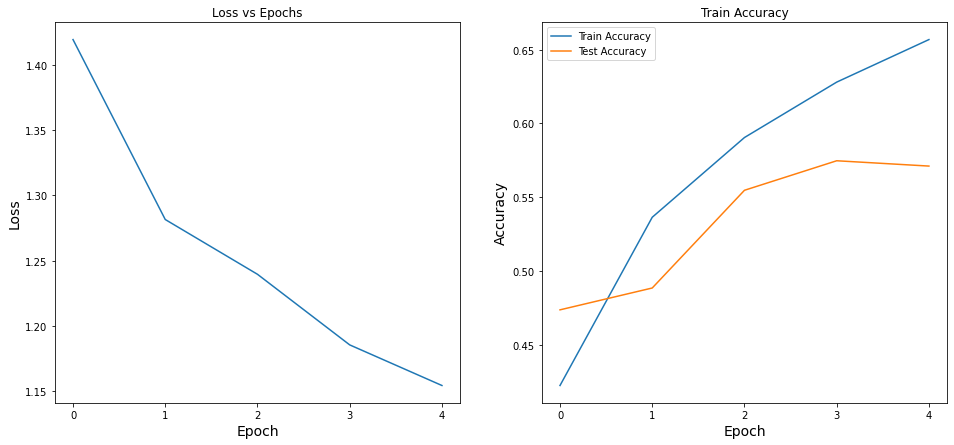

In [20]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16, 7))

axes[0].set_xticks(np.arange(0,epochs))

axes[0].set_xlabel("Epoch", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].set_title('Loss vs Epochs')
axes[0].plot(epochs_loss_out)

axes[1].set_title('Train Accuracy')
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(epochs_train_acc, label = 'Train Accuracy')

axes[1].plot(epochs_test_acc, label = 'Test Accuracy')

plt.legend()
plt.show()